In [1]:
import os
import csv
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim 
from torchvision import transforms, datasets
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from datetime import datetime
import torchvision.models as models


In [2]:
# 画像のサイズ
IMG_SIZE = 240

# データのディレクトリのパス
FLOWER_DIR = '../input/flowers'

batch_size = 32

model_name = "EfficientNetb1"

In [3]:
# GPUが利用可能かどうかを確認し、利用可能ならGPUを使用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


# データセットの作成

In [4]:
transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), # 画像サイズをリサイズ,
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# データセットを作成
dataset = datasets.ImageFolder(FLOWER_DIR, transform=transforms)


In [5]:
# 学習データに使用する割合
n_train_ratio = 0.8

# 割合から個数を出す
n_train = int(len(dataset) * n_train_ratio)
n_val   = int(len(dataset) - n_train)


In [6]:
# 学習データと検証データに分割
train, val = random_split(dataset, [n_train, n_val])


In [7]:
# Data Loader
train_loader = DataLoader(train, batch_size, shuffle=True, drop_last=True, num_workers=2)
val_loader = DataLoader(val, batch_size, num_workers=2)


In [8]:

class CustomEfficientNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomEfficientNet, self).__init__()
        self.efficientnet = models.efficientnet_b1(weights="IMAGENET1K_V1") 
        in_features = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier[1] = nn.Linear(in_features, num_classes)  # 新しい最終層を追加

    def forward(self, x):
        return self.efficientnet(x)


In [9]:
# 2. モデルの構築
model = CustomEfficientNet(num_classes=5).to(device)


In [10]:
# 3. 訓練と検証
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)



In [11]:
def train_and_evaluate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # 訓練フェーズ
        model.train()
        train_loss, train_correct = 0, 0
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}, Training...'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad(set_to_none=True)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()

        # 検証フェーズ
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs}, Validation...'):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()

        # 損失と精度の計算
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_accuracies.append(train_correct / len(train_loader.dataset))
        val_accuracies.append(val_correct / len(val_loader.dataset))

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train Acc: {train_accuracies[-1]}, Val Acc: {val_accuracies[-1]}')

    return train_losses, val_losses, train_accuracies, val_accuracies


In [12]:
train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate_model(model, train_loader, val_loader, criterion, optimizer)


Epoch 1/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 16.39it/s]


Epoch 1/50, Train Loss: 0.4390501031808764, Val Loss: 0.2864987118928521, Train Acc: 0.8456414711844773, Val Acc: 0.9108796296296297


Epoch 2/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 16.33it/s]


Epoch 2/50, Train Loss: 0.2561214886536108, Val Loss: 0.25105928422676194, Train Acc: 0.9122502172024327, Val Acc: 0.9340277777777778


Epoch 3/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 16.49it/s]


Epoch 3/50, Train Loss: 0.19076280678822616, Val Loss: 0.28914197782675427, Train Acc: 0.928467998841587, Val Acc: 0.9189814814814815


Epoch 4/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 16.25it/s]


Epoch 4/50, Train Loss: 0.1323004231448764, Val Loss: 0.24119766373877172, Train Acc: 0.94874022589053, Val Acc: 0.9282407407407407


Epoch 5/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 16.44it/s]


Epoch 5/50, Train Loss: 0.1308083267377637, Val Loss: 0.20106591091111856, Train Acc: 0.9481610194034173, Val Acc: 0.9317129629629629


Epoch 6/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 16.46it/s]


Epoch 6/50, Train Loss: 0.09862482688763988, Val Loss: 0.20390666931160484, Train Acc: 0.9606139588763394, Val Acc: 0.9363425925925926


Epoch 7/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 16.21it/s]


Epoch 7/50, Train Loss: 0.09455967955095432, Val Loss: 0.2280295231655516, Train Acc: 0.9588763394150015, Val Acc: 0.9317129629629629


Epoch 8/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 16.62it/s]


Epoch 8/50, Train Loss: 0.09254522518272225, Val Loss: 0.24846220940041044, Train Acc: 0.9582971329278888, Val Acc: 0.9340277777777778


Epoch 9/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 16.30it/s]


Epoch 9/50, Train Loss: 0.08225048263774853, Val Loss: 0.22940549395840476, Train Acc: 0.96293078482479, Val Acc: 0.9398148148148148


Epoch 10/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 16.49it/s]


Epoch 10/50, Train Loss: 0.06356892724756465, Val Loss: 0.29468347171873405, Train Acc: 0.9698812626701419, Val Acc: 0.9317129629629629


Epoch 11/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 16.00it/s]


Epoch 11/50, Train Loss: 0.09990052338776605, Val Loss: 0.2070211094148733, Train Acc: 0.9574283231972198, Val Acc: 0.9421296296296297


Epoch 12/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 17.13it/s]


Epoch 12/50, Train Loss: 0.0673276031972997, Val Loss: 0.2382447093863178, Train Acc: 0.9710396756443672, Val Acc: 0.9432870370370371


Epoch 13/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 15.51it/s]


Epoch 13/50, Train Loss: 0.06404029843223359, Val Loss: 0.27356602361908666, Train Acc: 0.9707500724008109, Val Acc: 0.9363425925925926


Epoch 14/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 16.22it/s]


Epoch 14/50, Train Loss: 0.06987902738815435, Val Loss: 0.29579784418456256, Train Acc: 0.9701708659136983, Val Acc: 0.9305555555555556


Epoch 15/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 16.36it/s]


Epoch 15/50, Train Loss: 0.06699936980083497, Val Loss: 0.27165103883103087, Train Acc: 0.9698812626701419, Val Acc: 0.9398148148148148


Epoch 16/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 17.12it/s]


Epoch 16/50, Train Loss: 0.06580163877801186, Val Loss: 0.23220959954239703, Train Acc: 0.9701708659136983, Val Acc: 0.9305555555555556


Epoch 17/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 16.47it/s]


Epoch 17/50, Train Loss: 0.05507208431949056, Val Loss: 0.25300136438562293, Train Acc: 0.9733565015928178, Val Acc: 0.9270833333333334


Epoch 18/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 16.71it/s]


Epoch 18/50, Train Loss: 0.03695249980235055, Val Loss: 0.2546878895653343, Train Acc: 0.9788589632203881, Val Acc: 0.9409722222222222


Epoch 19/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 16.54it/s]


Epoch 19/50, Train Loss: 0.049367003368320395, Val Loss: 0.41926306541319247, Train Acc: 0.9733565015928178, Val Acc: 0.9108796296296297


Epoch 20/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 16.33it/s]


Epoch 20/50, Train Loss: 0.08440656655481103, Val Loss: 0.29625883726058183, Train Acc: 0.9669852302345786, Val Acc: 0.9351851851851852


Epoch 21/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 15.99it/s]


Epoch 21/50, Train Loss: 0.043619344681425226, Val Loss: 0.27060124691989684, Train Acc: 0.9777005502461628, Val Acc: 0.9375


Epoch 22/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 14.55it/s]


Epoch 22/50, Train Loss: 0.03621418720217874, Val Loss: 0.25494520818918115, Train Acc: 0.9797277729510571, Val Acc: 0.9409722222222222


Epoch 23/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 14.46it/s]


Epoch 23/50, Train Loss: 0.036143253693655224, Val Loss: 0.23874015428763987, Train Acc: 0.980596582681726, Val Acc: 0.9479166666666666


Epoch 24/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 14.72it/s]


Epoch 24/50, Train Loss: 0.0159911327975912, Val Loss: 0.30538756831514613, Train Acc: 0.9863886475528526, Val Acc: 0.9375


Epoch 25/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 14.81it/s]


Epoch 25/50, Train Loss: 0.03596221589198811, Val Loss: 0.2776220966027015, Train Acc: 0.9785693599768317, Val Acc: 0.9398148148148148


Epoch 26/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 14.98it/s]


Epoch 26/50, Train Loss: 0.05986237400711871, Val Loss: 0.3807734551805037, Train Acc: 0.9695916594265855, Val Acc: 0.9259259259259259


Epoch 27/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 14.70it/s]


Epoch 27/50, Train Loss: 0.03910197049301013, Val Loss: 0.39029013734586815, Train Acc: 0.9785693599768317, Val Acc: 0.9212962962962963


Epoch 28/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 14.55it/s]


Epoch 28/50, Train Loss: 0.044225962348412896, Val Loss: 0.4384032185793061, Train Acc: 0.9745149145670432, Val Acc: 0.9305555555555556


Epoch 29/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 14.22it/s]


Epoch 29/50, Train Loss: 0.043983852923260215, Val Loss: 0.3530653254711069, Train Acc: 0.9765421372719374, Val Acc: 0.9247685185185185


Epoch 30/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 14.57it/s]


Epoch 30/50, Train Loss: 0.05117641114705965, Val Loss: 0.3142993437057292, Train Acc: 0.9765421372719374, Val Acc: 0.9282407407407407


Epoch 31/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 14.43it/s]


Epoch 31/50, Train Loss: 0.041842792668133955, Val Loss: 0.28188252280017845, Train Acc: 0.9794381697075007, Val Acc: 0.9305555555555556


Epoch 32/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 14.02it/s]


Epoch 32/50, Train Loss: 0.028001451473160882, Val Loss: 0.2694777634029311, Train Acc: 0.9834926151172894, Val Acc: 0.9421296296296297


Epoch 33/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 14.36it/s]


Epoch 33/50, Train Loss: 0.02904255120529767, Val Loss: 0.3707463665072013, Train Acc: 0.9832030118737329, Val Acc: 0.9363425925925926


Epoch 34/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 14.65it/s]


Epoch 34/50, Train Loss: 0.042443097812758984, Val Loss: 0.3361039938969986, Train Acc: 0.9791485664639444, Val Acc: 0.9201388888888888


Epoch 35/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 14.64it/s]


Epoch 35/50, Train Loss: 0.03763210689876104, Val Loss: 0.3880467455903137, Train Acc: 0.9788589632203881, Val Acc: 0.9340277777777778


Epoch 36/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 14.47it/s]


Epoch 36/50, Train Loss: 0.0464505762578245, Val Loss: 0.3559194343785445, Train Acc: 0.9771213437590501, Val Acc: 0.9212962962962963


Epoch 37/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 14.82it/s]


Epoch 37/50, Train Loss: 0.03484594604875196, Val Loss: 0.48153167283857734, Train Acc: 0.9771213437590501, Val Acc: 0.9131944444444444


Epoch 38/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 14.94it/s]


Epoch 38/50, Train Loss: 0.04013926985594183, Val Loss: 0.37607886700856463, Train Acc: 0.9768317405154938, Val Acc: 0.9363425925925926


Epoch 39/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 14.43it/s]


Epoch 39/50, Train Loss: 0.04323493227989317, Val Loss: 0.3886019555610363, Train Acc: 0.9762525340283811, Val Acc: 0.9293981481481481


Epoch 40/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 14.52it/s]


Epoch 40/50, Train Loss: 0.05366773580344585, Val Loss: 0.2842164672372207, Train Acc: 0.9750941210541558, Val Acc: 0.9386574074074074


Epoch 41/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 15.03it/s]


Epoch 41/50, Train Loss: 0.02987969547012934, Val Loss: 0.2655139704562586, Train Acc: 0.9811757891688387, Val Acc: 0.9421296296296297


Epoch 42/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 14.55it/s]


Epoch 42/50, Train Loss: 0.03170159092667609, Val Loss: 0.44883026366329026, Train Acc: 0.9820445988995077, Val Acc: 0.9178240740740741


Epoch 43/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 14.58it/s]


Epoch 43/50, Train Loss: 0.055206960310455556, Val Loss: 0.3791139955735869, Train Acc: 0.9756733275412685, Val Acc: 0.9189814814814815


Epoch 44/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 15.00it/s]


Epoch 44/50, Train Loss: 0.03771797071018465, Val Loss: 0.3501688830287161, Train Acc: 0.9791485664639444, Val Acc: 0.9317129629629629


Epoch 45/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 14.71it/s]


Epoch 45/50, Train Loss: 0.017929698844369835, Val Loss: 0.2876145855320997, Train Acc: 0.9860990443092963, Val Acc: 0.9502314814814815


Epoch 46/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 14.74it/s]


Epoch 46/50, Train Loss: 0.028402750874252362, Val Loss: 0.3559874959496988, Train Acc: 0.981465392412395, Val Acc: 0.9351851851851852


Epoch 47/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 14.55it/s]


Epoch 47/50, Train Loss: 0.03697651956395233, Val Loss: 0.2839582744571898, Train Acc: 0.9811757891688387, Val Acc: 0.9444444444444444


Epoch 48/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 14.61it/s]


Epoch 48/50, Train Loss: 0.0478072830439963, Val Loss: 0.3545682263319139, Train Acc: 0.9788589632203881, Val Acc: 0.9131944444444444


Epoch 49/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 14.65it/s]


Epoch 49/50, Train Loss: 0.026543576259801936, Val Loss: 0.2765765176154673, Train Acc: 0.9829134086301766, Val Acc: 0.9351851851851852


Epoch 50/50, Validation...: 100%|██████████| 27/27 [00:01<00:00, 14.37it/s]

Epoch 50/50, Train Loss: 0.02202699675304145, Val Loss: 0.3531546846842738, Train Acc: 0.9849406313350709, Val Acc: 0.9317129629629629


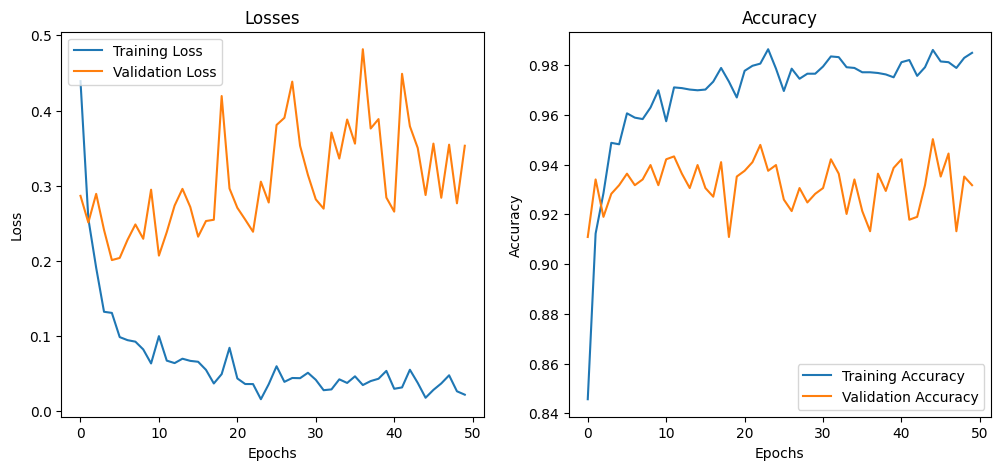

In [13]:
# グラフを保存するディレクトリを作成
output_dir = '../results'
os.makedirs(output_dir, exist_ok=True)

# タイムスタンプを生成
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# LossとAccuracyのデータをCSVファイルに保存
csv_filename = os.path.join(output_dir, f'{model_name}_{timestamp}.csv')
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy'])
    
    for epoch in range(len(train_losses)):
        writer.writerow([epoch+1, train_losses[epoch], val_losses[epoch], train_accuracies[epoch], val_accuracies[epoch]])


# Lossのグラフを保存
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title(f'Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracyのグラフを保存
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title(f'Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 画像を保存
plt.savefig(os.path.join(output_dir, f'{model_name}_{timestamp}.png'))

# 画像を表示
plt.show()
